In [1]:
import pandas as pd
import numpy as np
import nltk 
import collections
from nltk.tokenize import RegexpTokenizer

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

In [49]:
ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

Now let's get rid of the stop words

In [113]:
from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

We discarded 8545 stop words


In [115]:
print ("Out of {0} words, {1} are unique." 
        " Let's looks at those first.".format(len(word_tokens), 
                                           len(set(word_tokens))))

Out of 10129 words, 2201 are unique. Let's looks at those first.


Workflow:

1. Find the thirty most commonly occuring words.
   Report how often they appear
2. Perform part of speech tagging for the bag of words
   Characterize the distribution of parts of speech

In [116]:
word_tokens[:10]

['people',
 'popcorn',
 'candy',
 'soft',
 'drink',
 'costumes',
 'parading',
 'crowd',
 'people',
 'singing']

In [117]:
counter=collections.Counter(word_tokens)
assert sum(counter.values()) == len(word_tokens)

In [118]:
common_words = counter.most_common(30)

### Plotting word frequency

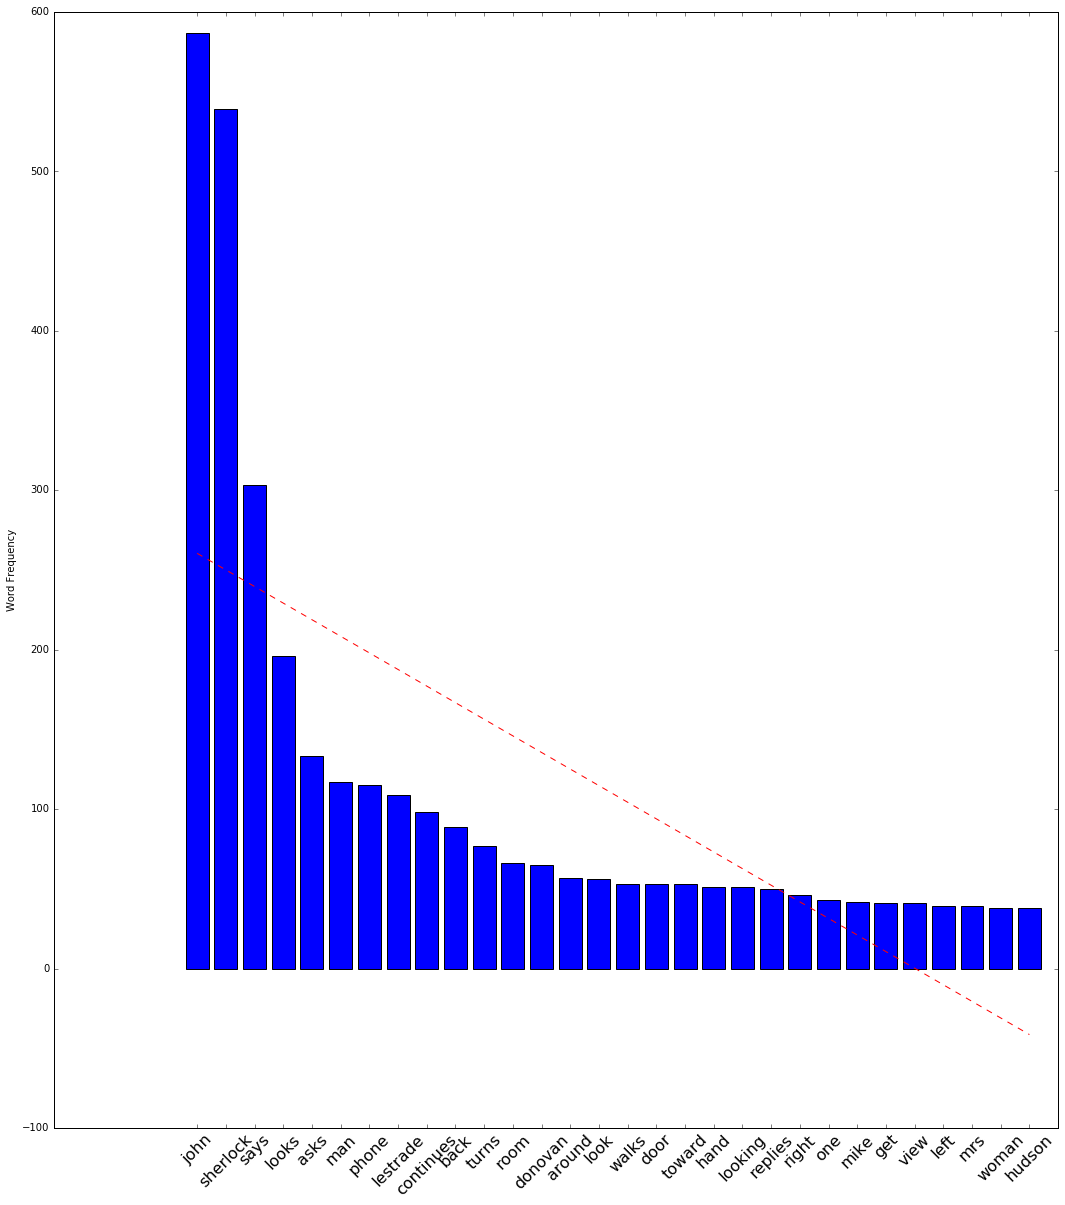

In [130]:
words = zip(*common_words)[0]
freq = zip(*common_words)[1]

x_pos = np.arange(len(words)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, words) 
plt.ylabel('Word Frequency')
plt.show()

In [131]:
# just working with unique words

only_unique_words = list(set(word_tokens))
tagged_words = nltk.pos_tag(only_unique_words)

In [169]:
tagged_words
pos_labels = [pos[1] for pos in tagged_words]
assert len(pos_labels) == len(tagged_words)

pos=collections.Counter(pos_labels)
counter_pos = [(p,pos[p]) for p in pos]

### Plotting part of speech frequency

In [171]:
labels = zip(*counter_pos)[0]
freq = zip(*counter_pos)[1]

In [172]:
x_pos = np.arange(len(labels)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

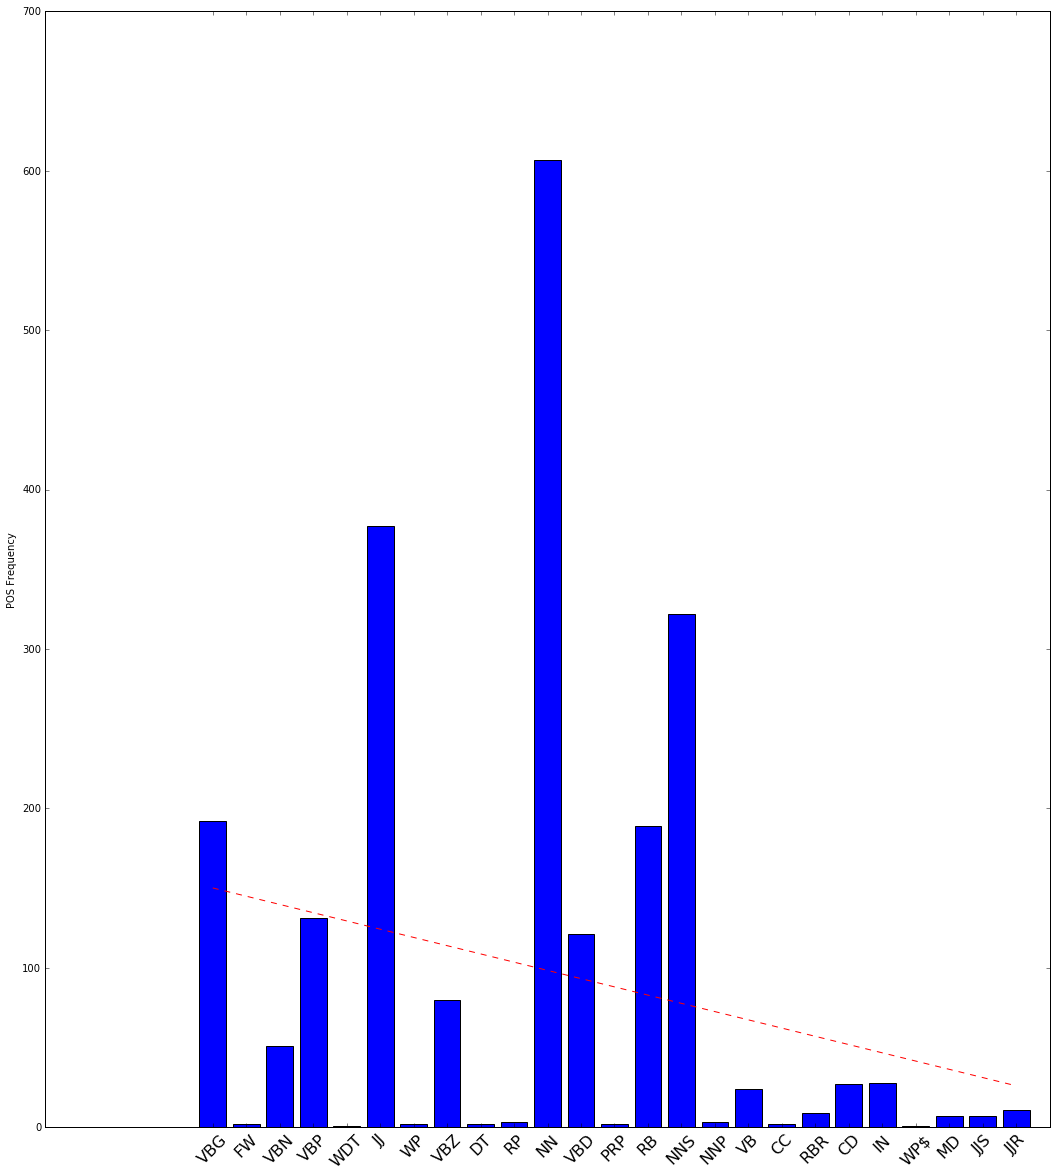

In [174]:
plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, labels) 
plt.ylabel('POS Frequency')
plt.show()

### Workflow for 08/02:

1. Find vecorized representations of all the words from the annotation
2. Try to use the TR segment onset annotations to create a dataset similar 
   to Alex Huth's formalism 

Basically, try to get as far as before training the regression model

In [2]:
# load trained feature vectors
glove_features = pd.read_table('/Users/vassiki/Desktop/MIND/projects/'
                            'scratch/GloVe-1.2/vectors.txt',header=None)
glove_features.columns = ['vectors']

words_and_vecs = glove_features['vectors'].tolist()
vecs = [[float(v) for v in s.split(" ")[1:]] for s in words_and_vecs]
wl = [s.split(" ")[0] for s in words_and_vecs]
# dimension of each vector is 50 

In [3]:
# put the vocabulary and vectors together in a data frame
lookup = pd.DataFrame({'words': wl, 'vectors': vecs})

In [4]:
# the previous approach takes really long, so we could read all the words
# in the annotation as a bag of words, and then use the feature vectors in the 
# bag of words as a lookup table
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

# let's get just the unique words

unique_words = list(set(word_tokens))

print "We have {0} unique words from the original {1}".format(len(unique_words),
                                                             len(word_tokens))

We discarded 8545 stop words
We have 2201 unique words from the original 10129


In [5]:
# creating lookup table for words uniquely in the dataframe
here_counter = 0
not_here_counter = 0
word_vectors = []
for i,widx in enumerate(unique_words):
    if i in range(100,2000,100):
        print ("working on the {0}th word").format(i)
    if widx in lookup['words'].tolist():
        where_idx = lookup.index[lookup['words'] == widx][0]
        word_vectors.append(lookup['vectors'][where_idx])
        #print "{0} is here".format(widx)
        here_counter += 1
    else:
        #print "{0} isn't here".format(widx)
        word_vectors.append(([0]*len(lookup['vectors'][0])))
        not_here_counter += 1   
        
assert len(word_vectors) == len(unique_words)

working on the 100th word
working on the 200th word
working on the 300th word
working on the 400th word
working on the 500th word
working on the 600th word
working on the 700th word
working on the 800th word
working on the 900th word
working on the 1000th word
working on the 1100th word
working on the 1200th word
working on the 1300th word
working on the 1400th word
working on the 1500th word
working on the 1600th word
working on the 1700th word
working on the 1800th word
working on the 1900th word


In [6]:
unique_lookup = pd.DataFrame({'words':unique_words,'vectors':word_vectors})

In [7]:
print "Out of {0} words, we have features for {1} \
and not for {2}".format(len(unique_words),
                        here_counter,not_here_counter)

Out of 2201 words, we have features for 1953 and not for 248


In [8]:
# create a copy of the dataframe
# get the column with words from sherlock

df = ann_df.copy()
# remove non ascii chars

# first clean up words in the rows
df["Words"] = ""
#for idx,row in enumerate(df['Scene Details - A Level ']):
for idx in range(df.shape[0]):
    row = df['Scene Details - A Level '][idx]
    if pd.isna(row):
        iter_row = str(row)
    else:
        iter_row = row.encode('ascii','ignore')
    #df.at[idx,"Words"] = [a.encode('ascii','ignore') 
    #                      for a in iter_row.split(" ")]
    asciify = [a.encode('ascii','ignore') 
                          for a in iter_row.split(" ")]
    
    # create tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens_list = [tokenizer.tokenize(a_string) for a_string in asciify]
    tokens = [t for tok in tokens_list for t in tok]
    df.at[idx,"Words"] = tokens



In [9]:
# now that we have features for the unique words, we can go through a lookup
# table created by these words an their features in the annotation data frame
df["Word Vectors"] = ""
df["Average Vector"]

for idx in range(df.shape[0]):
    if idx in range(200,1000,200):
        print "Working on word {0}".format(idx)
    word_vec=[]
    tr_words = df["Words"][idx]
    for tr_word in tr_words:
        if tr_word.lower() in unique_lookup['words'].tolist():
            where_idx = unique_lookup.index[unique_lookup['words'] 
                                        == tr_word.lower()][0]
            word_vec.append(unique_lookup['vectors'][where_idx])
        else:
            word_vec.append(([0]*len(lookup['vectors'][0])))
    df.at[idx,"Word Vectors"] = word_vec


Working on word 200
Working on word 400
Working on word 600
Working on word 800


In [22]:
# now we create a new column that simply averages the word vectors
# for each TR

df["Average Vector"] = [np.mean(row,axis=0) for row in df["Word Vectors"]]
df["Semantic Point"] = [np.mean(row) for row in df["Word Vectors"]]

df["Surprise Diff"] = df["Semantic Point"].diff()

In [ ]:
# more ideas: feature vectors for only dialog in a given segment,
#             compare with feature vectors all description in each segment  

In [ ]:
# add them up

In [15]:
df.head()

Segment Number  Start Time (s)   End Time (s)   Start Time (TRs, 1.5s)  \
0               1                0             12                     1.0   
1               2               12             15                     9.0   
2               3               15             17                    11.0   
3               4               17             23                    12.0   
4               5               23             29                    16.0   

   End Time (TRs, 1.5s) Scene Segments  \
0                   8.0     1. Cartoon   
1                  10.0            NaN   
2                  11.0            NaN   
3                  15.0            NaN   
4                  19.0            NaN   

                            Scene Details - A Level  Space-In/Outdoor  \
0  People in popcorn, candy, and soft drink costu...           Indoor   
1  Popcorn is being popped in a large popcorn mac...           Indoor   
2    Men sing in reply: "the popcorn can't be beat!"           Indoor   
3  A family of four, a father with a black suit, ...           Indoor   
4  A view of the lobby with a display of snacks f...           Indoor   

                          Name - All                 Name - Focus  \
0        Cartoon People in Costumes   Cartoon People in Costumes    
1                      Female Singer                          NaN   
2                       Male Singers                          NaN   
3                 Background Singers                          NaN   
4  Cartoon Woman, Background Singers                Cartoon Woman   

        ...       Arousal - Rater 2 Valence - Rater 2 Arousal - Rater 3  \
0       ...                       1                 +                 2   
1       ...                       1                 +                 2   
2       ...                       1                 +                 2   
3       ...                       1                 +                 2   
4       ...                       1                 +                 1   

  Valence - Rater 3 Arousal - Rater 4  Valence - Rater 4  \
0                 +                 3                  +   
1                 +                 2                  +   
2                 +                 2                  +   
3                 +                 2                  +   
4                 +                 2                  +   

                                               Words  \
0  [People, in, popcorn, candy, and, soft, drink,...   
1  [Popcorn, is, being, popped, in, a, large, pop...   
2  [Men, sing, in, reply, the, popcorn, can, t, b...   
3  [A, family, of, four, a, father, with, a, blac...   
4  [A, view, of, the, lobby, with, a, display, of...   

                                        Word Vectors  \
0  [[-0.805949, -1.863783, -0.610931, -0.451316, ...   
1  [[0.12985, 0.120268, -0.187086, 0.277843, -0.0...   
2  [[0.016389, -1.275518, -0.221122, -0.396952, -...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      Average Vector  Semantic Point  
0  [-0.119147166667, -0.286508233333, -0.06574433...        0.000362  
1  [-0.18140835, -0.2569148, -0.0143628, -0.20212...       -0.009056  
2  [-0.0251514, -0.1716565, -0.1199145, -0.112061...        0.003943  
3  [-0.19809834375, -0.2827373125, -0.05374723437...       -0.000001  
4  [-0.1580504, -0.114774085714, -0.0176809142857...        0.003361  

[5 rows x 27 columns]